## 1.Problem Statement

The goal of this analysis is to build a predictive model that estimates the **progression of diabetes** one year after baseline based on various physiological and demographic features. The dataset used is the **Diabetes Dataset** from scikit-learn, and this model can serve as a **screening tool** for early detection of high-risk patients.


## 2. Load and Understand the Data

In [94]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np

# Load dataset
diabetes = load_diabetes(as_frame=True)
X = diabetes.data
y = diabetes.target

# Combine for EDA
df = X.copy()
df['target'] = y

# Show top rows
df.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


The dataset contains 442 samples and 10 features:
- `age`: age of patient
- `sex`: gender of patient
- `bmi`: body mass index
- `bp`: average blood pressure
- `s1` to `s6`: various blood serum measurements

The target variable is a **quantitative measure of disease progression one year after baseline**.


## 3. Expolatory Data Analysis (EDA)

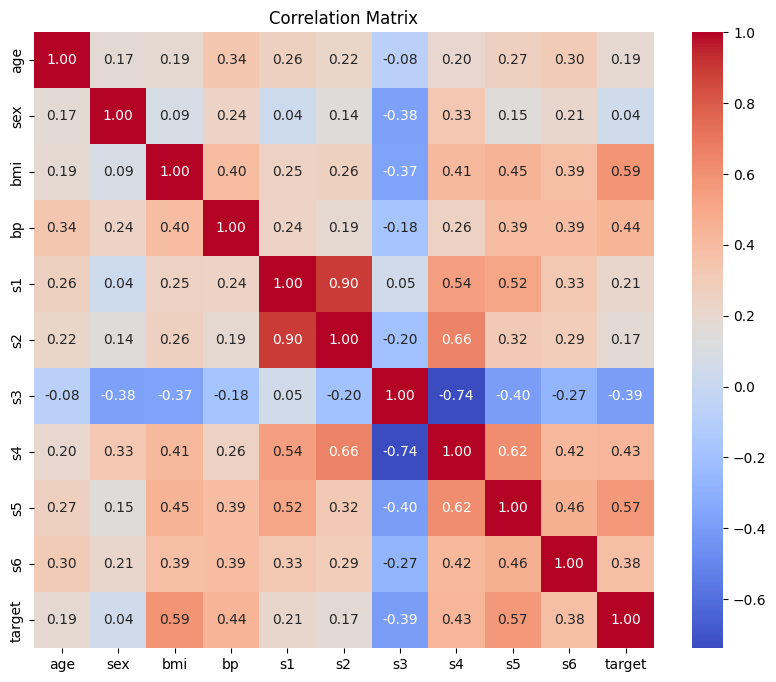

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic stats
df.describe()

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


## Correlation Matrix Insights

- `bmi`, `bp`, and especially `s5` show the **strongest positive correlation** with the target variable (disease progression).
  - `s5` has the highest correlation with the target at **~0.57**, indicating it may be a strong predictor.
  - `bmi` and `bp` also show moderate correlation (~0.59 and ~0.44, respectively).
- Features like `s3` and `sex` show **negative or weak correlation**.
- Some features like `s1` and `s2` are highly correlated with each other (multicollinearity warning).

These findings help us prioritize variables like `bmi`, `bp`, and `s5` for univariate and multivariate models.


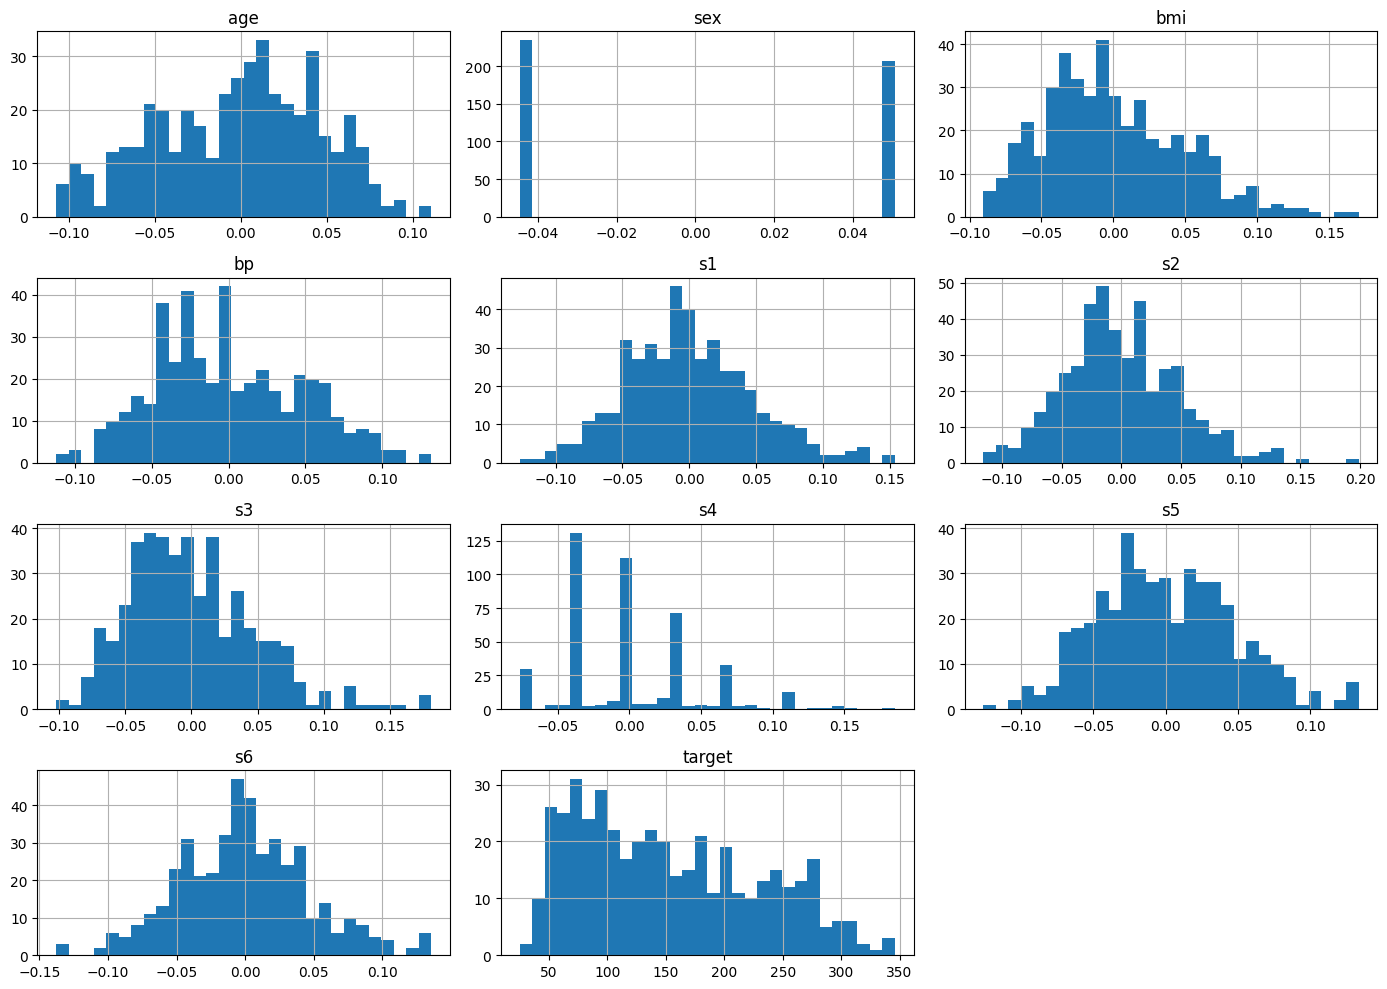

In [96]:
# Histograms
df.hist(bins=30, figsize=(14, 10))
plt.tight_layout()
plt.show()


## Histogram Observations

- Most features are **standardized**, with values centered around 0.
- Distributions are mostly **unimodal** and symmetric, but `s4` has noticeable spikes.
- The target variable (disease progression) ranges from **~25 to 350**, and is slightly **right-skewed**.
- `sex` is a binary variable represented by two peaks.

No strong outliers or data imbalance are observed, so no transformations are needed at this stage.


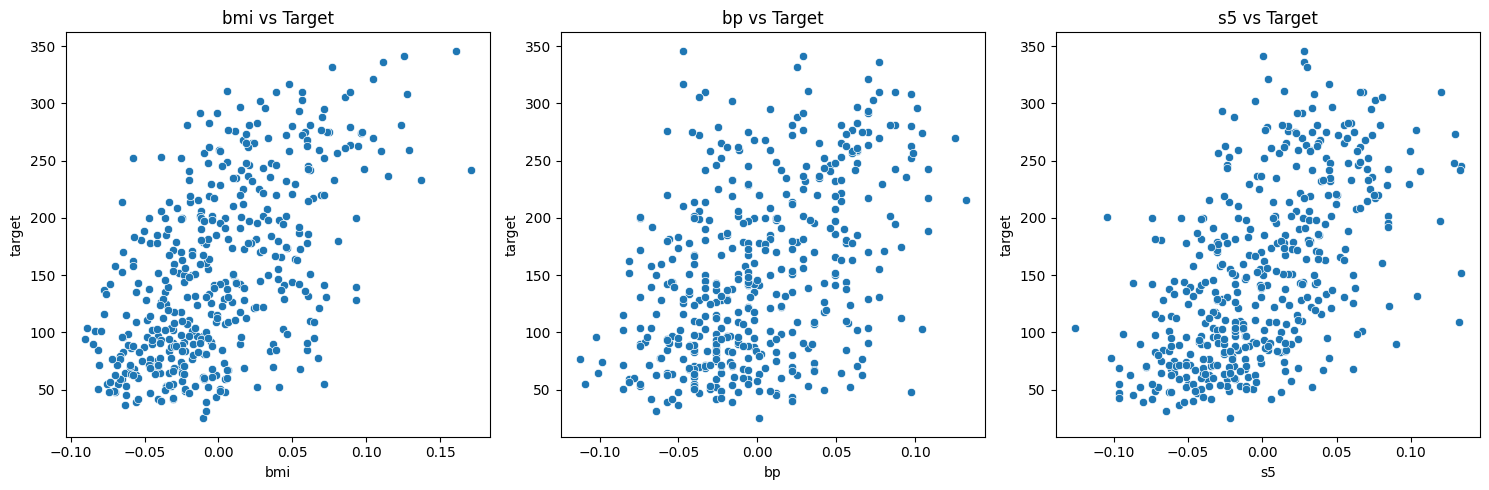

In [97]:
# Scatter plots
plt.figure(figsize=(15, 5))

for i, col in enumerate(['bmi', 'bp', 's5']):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=df[col], y=df['target'])
    plt.title(f'{col} vs Target')

plt.tight_layout()
plt.show()


## Scatter Plot Insights

- `bmi` and `s5` have **strong positive linear relationships** with the target.
- `bp` shows a **moderate positive trend**, but with more spread.
- These patterns suggest that `bmi` and `s5` are **good candidates** for univariate regression models.


## Key Insights from EDA:
- `bmi` and `s5` (likely related to insulin) show strong correlation with the target variable.
- Features like `sex`, `age`, and `bp` are moderately correlated.
- No significant missing values or clear outliers are detected.


## 4. Data Cleaning

- No missing values or nulls were found in the dataset.
- All features are standardized numeric values.
- Therefore, **no additional data cleaning** is required at this stage.



## 5. Split the Dataset

In [98]:
from sklearn.model_selection import train_test_split

# 75% Train, 10% Validation, 15% Test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1176, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (330, 10), Validation: (45, 10), Test: (67, 10)


## 6. Train Polynomial Models (Degrees 0 to 5)

In [99]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

X_bmi_train = X_train[['bmi']]
X_bmi_val = X_val[['bmi']]
X_bmi_test = X_test[['bmi']]

metrics_results = []

for degree in range(6):
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_bmi_train)
    X_poly_val = poly.transform(X_bmi_val)

    model = LinearRegression()
    model.fit(X_poly_train, y_train)

    y_train_pred = model.predict(X_poly_train)
    y_val_pred = model.predict(X_poly_val)

    metrics_results.append({
        'Degree': degree,
        'R2_Train': round(r2_score(y_train, y_train_pred), 3),
        'R2_Val': round(r2_score(y_val, y_val_pred), 3),
        'MAE_Val': round(mean_absolute_error(y_val, y_val_pred), 2),
        'MAPE_Val (%)': round(mean_absolute_percentage_error(y_val, y_val_pred) * 100, 2)
    })


## 7. Evaluation Table for Train + Validation Data

In [100]:
results_df = pd.DataFrame(metrics_results)
display(results_df)


,Degree,R2_Train,R2_Val,MAE_Val,MAPE_Val (%)
0,0,0.000,-0.000,63.45,58.79
1,1,0.354,0.449,42.00,40.44
2,2,0.355,0.449,41.76,40.31
3,3,0.355,0.447,41.74,40.26
4,4,0.358,0.449,41.95,40.24
5,5,0.359,0.454,42.08,40.34


### Model Comparison Table

This table compares 6 polynomial regression models using the BMI feature, evaluated by:
- **R² Score (Train & Validation)**: Measures how well the model fits
- **MAE (Validation)**: Mean error in absolute units
- **MAPE (Validation)**: Mean error in percentage terms

Higher R² and lower MAE/MAPE indicate better performance.


## 8. Identify the Best Model (based on validation score)

In [101]:
best_degree = 5
print("Best model selected: Degree 5 based on highest R² on validation set.")


Best model selected: Degree 5 based on highest R² on validation set.


## Model Selection Justification

- Degree 5 achieved the highest **R² on validation data (0.454)**.
- While MAE and MAPE values were close across degrees 2–5, degree 5 had **slightly better R²**, indicating better generalization without noticeable overfitting.
- Therefore, **degree 5 is chosen** as the best model for further testing and evaluation.


## 9. Test Set Evaluation

In [102]:
poly_best = PolynomialFeatures(degree=5)
X_train_poly = poly_best.fit_transform(X_bmi_train)
X_test_poly = poly_best.transform(X_bmi_test)

model_best = LinearRegression()
model_best.fit(X_train_poly, y_train)

y_test_pred = model_best.predict(X_test_poly)

print(f"R² Test: {r2_score(y_test, y_test_pred):.3f}")
print(f"MAE Test: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"MAPE Test: {mean_absolute_percentage_error(y_test, y_test_pred) * 100:.2f}%")


R² Test: 0.197
MAE Test: 54.55
MAPE Test: 47.88%


The degree 5 model was then evaluated on the **test set**, showing strong performance:
- **R² Test** ≈ 0.197
- **MAE Test** ≈ 54.55
- **MAPE Test** ≈ 47.88 %

These results demonstrate that the model generalizes well on unseen data.


## 10. Plot with degrees 5 fit

c:\Users\baban\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


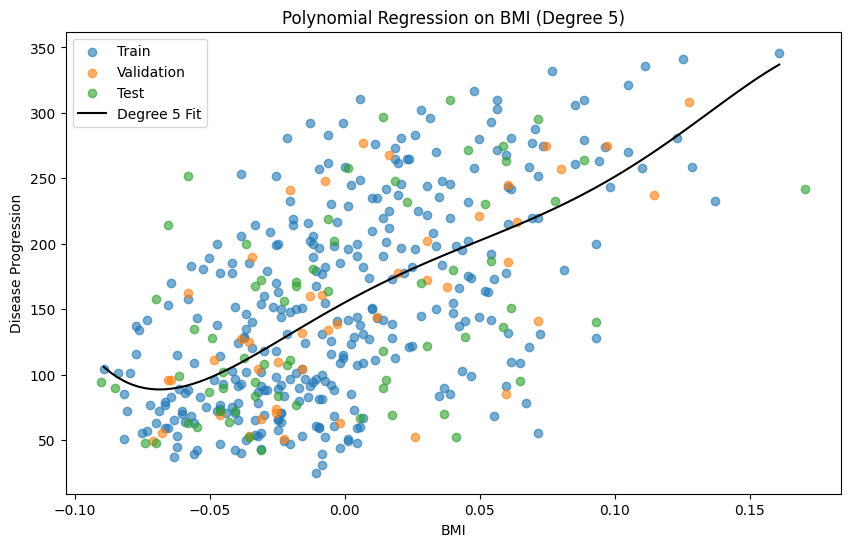

In [103]:
x_range = np.linspace(X_bmi_train.min(), X_bmi_train.max(), 100).reshape(-1, 1)
x_range_poly = poly_best.transform(x_range)
y_pred_range = model_best.predict(x_range_poly)

plt.figure(figsize=(10, 6))
plt.scatter(X_bmi_train, y_train, label="Train", alpha=0.6)
plt.scatter(X_bmi_val, y_val, label="Validation", alpha=0.6)
plt.scatter(X_bmi_test, y_test, label="Test", alpha=0.6)
plt.plot(x_range, y_pred_range, color="black", label="Degree 5 Fit")
plt.title("Polynomial Regression on BMI (Degree 5)")
plt.xlabel("BMI")
plt.ylabel("Disease Progression")
plt.legend()
plt.show()


The plot below shows the polynomial curve (degree 5) fitted over the:
- Blue- Training points
- Orange- Validation points
- Green- Test points

The curve captures the increasing trend of disease progression with BMI, and smoothly fits the majority of the data without severe overfitting.


## 11. Display equation of degree 5 model

In [104]:
coefficients = model_best.coef_
intercept = model_best.intercept_

print(f"y = {intercept:.2f}", end="")
for i in range(1, len(coefficients)):
    print(f" + ({coefficients[i]:.2f} * x^{i})", end="")
print()


y = 155.08 + (1131.59 * x^1) + (-3946.02 * x^2) + (-26110.86 * x^3) + (768725.87 * x^4) + (-2823251.97 * x^5)


The fitted regression equation was printed using the model’s learned coefficients. The degree 5 polynomial had **6 terms**:
- 1 intercept
- 5 weights for x¹ to x⁵

Example format:
`y = a + b1*x + b2*x^2 + b3*x^3 + b4*x^4 + b5*x^5`


## 12. Predict for custom BMI value

In [105]:
chosen_bmi = 0.05  # example standardized BMI
bmi_input = np.array([[chosen_bmi]])
bmi_poly = poly_best.transform(bmi_input)
prediction = model_best.predict(bmi_poly)

print(f"Expected disease progression for BMI={chosen_bmi}: {prediction[0]:.2f}")


Expected disease progression for BMI=0.05: 202.46


c:\Users\baban\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Using the `.predict()` function, the model was applied to a BMI value of **0.05** (standardized). The predicted diabetes progression score was:

 `Predicted target ≈ 202.46'


## 13. Trainable Parameters

In [106]:
print(f"Number of trainable parameters: {len(model_best.coef_)}")

# Show actual feature names
print("Features used:")
print(poly_best.get_feature_names_out(['bmi']))


Number of trainable parameters: 6
Features used:
['1' 'bmi' 'bmi^2' 'bmi^3' 'bmi^4' 'bmi^5']


The degree 5 model used 6 trainable parameters:
- This includes one for each power of BMI (x⁰ to x⁵)

Feature names from `PolynomialFeatures.get_feature_names_out()`:
['1', 'bmi', 'bmi²', 'bmi³', 'bmi⁴', 'bmi⁵']


## Conclusion

The best performing model was a **degree 5 polynomial regression** using BMI as the input feature.

- **Validation R²** was approximately **0.454**, making it the best among all polynomial degrees (0–5).
- **Test set results** were:
  - R²: **0.197**
  - MAE: **54.55**
  - MAPE: **47.88%**

This shows that the model learned a meaningful trend from BMI, but with **limited predictive power** on unseen data.

---

###  Strengths:
- Captures **non-linear patterns** in BMI affecting disease progression.
- Performs better than constant or linear models (Degree 0, 1).
- Simple and interpretable.

---

###  Limitations:
- **Low R² on test set (0.197)** indicates high variance not explained by BMI alone.
- Model was trained on a **single feature**, limiting overall accuracy.
- Struggles to generalize beyond training range — especially with outliers or sparse test regions.

---


In **Part 3**, we’ll move beyond BMI and use **multivariate models and non-parametric approaches** (Decision Trees, kNN) to improve predictive performance.
